
# Introduction to Web Scraping with **Scrapy** (Python)



## Quick Start: 3 Essential Capabilities

We'll demonstrate three bread‑and‑butter tasks:
1. **Install & scaffold** a Scrapy project.
2. **Write a minimal spider** to grab book data from one page.
3. **Follow pagination** and **export to CSV** with one setting.

> These cells show commands you run in a terminal. In Jupyter, you can run them with `%%bash`.


In [38]:
# Package imports 

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
import scrapy
import seaborn as sns
from urllib.parse import urljoin

In [ ]:
%%bash
## 1 ##


# (1) Install Scrapy in your environment (uncomment if needed).
# It's best to do this in a clean virtualenv or conda env.

# pip install --upgrade pip
# pip install scrapy


In [40]:
%%bash
scrapy startproject bookdemo

## 2 ##


# (2) Create a Scrapy project scaffold (run once).
# This creates a folder 'bookdemo' with the standard Scrapy layout.
# If the project already exists, this will error—it's safe to ignore.



New Scrapy project 'bookdemo', using template directory '/opt/anaconda3/lib/python3.12/site-packages/scrapy/templates/project', created in:
    /Users/ahmedehtisham/Downloads/bookdemo

You can start your first spider with:
    cd bookdemo
    scrapy genspider example example.com



### Project layout (created by `scrapy startproject bookdemo`)
```
bookdemo/
├─ bookdemo/            # Python package for the project
│  ├─ spiders/          # Your spiders live here
│  ├─ __init__.py
│  ├─ items.py
│  ├─ middlewares.py
│  ├─ pipelines.py
│  └─ settings.py
└─ scrapy.cfg           # Deployment configuration
```


In [42]:
%%bash
## 3 ##


# (3) Create a basic spider file.
# We'll put a spider that scrapes book data from the first page.
# NOTE: You can also do: cd bookdemo && scrapy genspider books books.toscrape.com
# Here, we write a spider directly to keep the notebook self-contained. 

set -e

mkdir -p bookdemo/bookdemo/spiders

cat > bookdemo/bookdemo/spiders/books_basic.py << 'PY'

import scrapy

class BooksBasicSpider(scrapy.Spider):
    """Minimal spider: scrapes the first page of 'Books to Scrape'."""
    name = "books_basic"
    allowed_domains = ["books.toscrape.com"]
    start_urls = ["https://books.toscrape.com/"]

    def parse(self, response):
        # Select all product cards on the page
        for product in response.css("article.product_pod"):
            yield {
                "title": product.css("h3 a::attr(title)").get(),
                "price": product.css(".price_color::text").get(),
                "availability": product.css(".availability::text").getall()[-1].strip(),
                "product_url": response.urljoin(product.css("h3 a::attr(href)").get()),
            }
PY



In [44]:
%%bash
cd bookdemo && scrapy crawl books_basic -O books_basic.csv

## 4 ##


# (4) Run the spider and export to CSV using FEEDS, limited to one page.
# Note: If you are in a network-restricted environment, this will fail.
# In your local setup, run this in a terminal





2025-11-02 16:35:58 [scrapy.utils.log] INFO: Scrapy 2.11.1 started (bot: bookdemo)
2025-11-02 16:35:58 [scrapy.utils.log] INFO: Versions: lxml 5.2.1.0, libxml2 2.10.4, cssselect 1.2.0, parsel 1.8.1, w3lib 2.1.2, Twisted 23.10.0, Python 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:07:17) [Clang 14.0.6 ], pyOpenSSL 24.0.0 (OpenSSL 3.0.15 3 Sep 2024), cryptography 42.0.5, Platform macOS-15.6.1-arm64-arm-64bit
2025-11-02 16:35:58 [scrapy.addons] INFO: Enabled addons:
[]
2025-11-02 16:35:58 [asyncio] DEBUG: Using selector: KqueueSelector
2025-11-02 16:35:58 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.asyncioreactor.AsyncioSelectorReactor
2025-11-02 16:35:58 [scrapy.utils.log] DEBUG: Using asyncio event loop: asyncio.unix_events._UnixSelectorEventLoop
2025-11-02 16:35:58 [scrapy.extensions.telnet] INFO: Telnet Password: a3db354701127db5
2025-11-02 16:35:58 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions


### Upgrade: Follow Pagination & Export All Pages

Now let's follow **next page** links to scrape the entire catalog.
We'll also set **FEEDS** in `settings.py` so a CSV is produced automatically.


In [46]:
%%bash

## 5 ##


# Write a pagination-capable spider.
set -e

cat > bookdemo/bookdemo/spiders/books_paged.py << 'PY'

import scrapy
from urllib.parse import urljoin   # you also use urljoin later

class BooksPagedSpider(scrapy.Spider):
    """Spider that follows pagination to scrape the entire catalog."""
    name = "books_paged"
    allowed_domains = ["books.toscrape.com"]
    start_urls = ["https://books.toscrape.com/"]

    custom_settings = {
        # Export to CSV without passing -O on the command line
        "FEEDS": {"books_paged.csv": {"format": "csv", "overwrite": True}},
        # Be polite
        "ROBOTSTXT_OBEY": True,
        "DOWNLOAD_DELAY": 0.5,
        "AUTOTHROTTLE_ENABLED": True,
        "AUTOTHROTTLE_START_DELAY": 0.5,
        "AUTOTHROTTLE_MAX_DELAY": 5.0,
        "USER_AGENT": "Scrapy-Teaching-Bot (+https://example.org/edu)",
    }

    def parse(self, response):
        # Extract books on the current page
        for product in response.css("article.product_pod"):
            yield {
                "title": product.css("h3 a::attr(title)").get(),
                "price": product.css(".price_color::text").get(),
                "availability": product.css(".availability::text").getall()[-1].strip(),
                "product_url": response.urljoin(product.css("h3 a::attr(href)").get()),
                "rating": product.css("p.star-rating::attr(class)").re_first("star-rating\s+(\w+)"),
                "category": response.css(".breadcrumb li:nth-child(3) a::text").get(default="All"),
            }

        # Follow "next" page if present
        next_rel = response.css("li.next a::attr(href)").get()
        if next_rel:
            next_url = urljoin(response.url, next_rel)
            yield response.follow(next_url, callback=self.parse)
PY



In [48]:
%%bash

## 6 ##


# To run and create 'books_paged.csv' locally:


cd bookdemo && scrapy crawl books_paged



/Users/ahmedehtisham/Downloads/bookdemo/bookdemo/spiders/books_paged.py:31: SyntaxWarning: invalid escape sequence '\s'
  "rating": product.css("p.star-rating::attr(class)").re_first("star-rating\s+(\w+)"),
2025-11-02 16:36:05 [scrapy.utils.log] INFO: Scrapy 2.11.1 started (bot: bookdemo)
2025-11-02 16:36:05 [scrapy.utils.log] INFO: Versions: lxml 5.2.1.0, libxml2 2.10.4, cssselect 1.2.0, parsel 1.8.1, w3lib 2.1.2, Twisted 23.10.0, Python 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:07:17) [Clang 14.0.6 ], pyOpenSSL 24.0.0 (OpenSSL 3.0.15 3 Sep 2024), cryptography 42.0.5, Platform macOS-15.6.1-arm64-arm-64bit
2025-11-02 16:36:05 [scrapy.addons] INFO: Enabled addons:
[]
2025-11-02 16:36:05 [asyncio] DEBUG: Using selector: KqueueSelector
2025-11-02 16:36:05 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.asyncioreactor.AsyncioSelectorReactor
2025-11-02 16:36:05 [scrapy.utils.log] DEBUG: Using asyncio event loop: asyncio.unix_events._UnixSelectorEventLoop
2025-11


## Deep Dive: Scrapy Concepts (Short & Practical)

### 1) Project & Spiders
- A **project** organizes settings, pipelines, and spiders.
- A **spider** is a class that defines `start_urls` and a `parse` method that yields items/requests.

### 2) Selectors (CSS/XPath)
- Use `response.css("selector")` or `response.xpath("//path")`.
- `.get()` returns the first match or `None`; `.getall()` returns all.

### 3) Following Links
- Use `response.follow(href, callback=self.parse)` or `urljoin` for absolute URLs.

### 4) Exporting Data
- Quickest path: `-O output.csv` on the crawl command.
- Or set `FEEDS` in settings or per-spider `custom_settings`.

### 5) Be Polite & Resilient
- Respect `robots.txt`: `ROBOTSTXT_OBEY = True`.
- Use `DOWNLOAD_DELAY` and `AUTOTHROTTLE`.
- Set a clear `USER_AGENT`. Handle errors or missing selectors gracefully.



### Items & Pipelines (Optional for Quick Start, Great for Robustness)

**Items**: typed containers for your data.  
**Pipelines**: post-process items (clean, validate, store to DB).



In [50]:
%%bash
## 7 ##


# Write minimal Item and Pipeline examples.
set -e

# Create items.py

cat > bookdemo/bookdemo/items.py << 'PY'

# This defines what data fields each scraped book will have, basically the “shape” of the data.
# Each scrapy.Field() marks a value you’ll extract from a website.

import scrapy


class BookItem(scrapy.Item):
    """Structured container for book fields."""
    title = scrapy.Field()
    price = scrapy.Field()
    availability = scrapy.Field()
    product_url = scrapy.Field()
    rating = scrapy.Field()
    category = scrapy.Field()
PY

# Create pipelines.py

cat > bookdemo/bookdemo/pipelines.py << 'PY'


# The pipeline is used to clean and process scraped items before saving them.

# Inside process_item:
    # Converts text like $12.99 → 12.99 (float).
    # Turns In stock → True (boolean).
    # Maps star ratings like Three → 3 (number).

# Every scraped book passes through this cleaning step automatically.

import re

class CleanBookPipeline:
    """Clean/transform book fields, e.g., normalize price to float."""
    price_pattern = re.compile(r"[\d.]+")

    def process_item(self, item, spider):
        price_text = item.get("price") or ""
        match = self.price_pattern.search(price_text)
        item["price"] = float(match.group(0)) if match else None

        # Normalize availability to a boolean
        avail_text = (item.get("availability") or "").lower()
        item["available"] = "in stock" in avail_text or "availability" in avail_text

        # map rating words to numbers
        rating_map = {"One": 1, "Two": 2, "Three": 3, "Four": 4, "Five": 5}
        item["rating_num"] = rating_map.get(item.get("rating"), None)
        return item
PY

# Enable pipeline in settings
python - << 'PY'

from pathlib import Path

settings_path = Path("bookdemo/bookdemo/settings.py")
txt = settings_path.read_text(encoding="utf-8")
if "ITEM_PIPELINES" not in txt:
    txt += "\n\nITEM_PIPELINES = {\n    'bookdemo.pipelines.CleanBookPipeline': 300,\n}\n"
settings_path.write_text(txt, encoding="utf-8")
print("Enabled CleanBookPipeline in settings.py")
PY



Enabled CleanBookPipeline in settings.py



> With the pipeline enabled, any spider that yields a dict with matching keys—or a `BookItem`—will be cleaned automatically.



## Data Analysis of the Scraped CSV

Once you've run `books_paged` (or `books_basic`), you should have a CSV (e.g., `books_paged.csv`).  
Let's load it in Python, clean types, and do a few basic plots.


In [52]:
## 8 ##

df = pd.read_csv("bookdemo/books_paged.csv")


print(df.head(3))


                  title   price availability  \
0  A Light in the Attic  £51.77     In stock   
1    Tipping the Velvet  £53.74     In stock   
2            Soumission  £50.10     In stock   

                                         product_url rating category  
0  https://books.toscrape.com/catalogue/a-light-i...  Three      All  
1  https://books.toscrape.com/catalogue/tipping-t...    One      All  
2  https://books.toscrape.com/catalogue/soumissio...    One      All  


In [54]:
## 9 ##

# Basic cleaning and type conversions
def coerce_price(series):
    """Convert price strings like '£51.77' to floats. If already floats, return as-is."""
    if series.dtype.kind in "iufc":
        return series.astype(float)
    return (series.astype(str)
                 .str.extract(r'([\d.]+)')[0]
                 .astype(float))

df['price'] = coerce_price(df.get('price', pd.Series(dtype=float)))
if 'rating_num' not in df.columns:
    # Map rating words to numbers needed
    rating_map = {"One": 1, "Two": 2, "Three": 3, "Four": 4, "Five": 5}
    df['rating_num'] = df.get('rating', pd.Series(dtype=str)).map(rating_map)

# Simple sanity checks
print(df[['price', 'rating_num']].describe(include='all'))


            price   rating_num
count  1000.00000  1000.000000
mean     35.07035     2.923000
std      14.44669     1.434967
min      10.00000     1.000000
25%      22.10750     2.000000
50%      35.98000     3.000000
75%      47.45750     4.000000
max      59.99000     5.000000


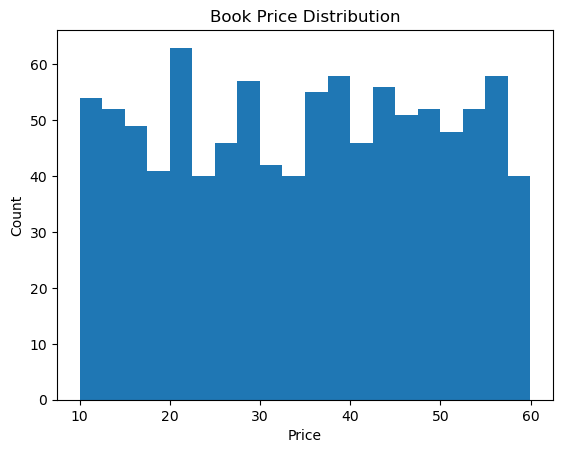

In [56]:
## 10 ##

# Plot 1: Price distribution
plt.figure()
df['price'].dropna().plot(kind='hist', bins=20, title='Book Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()


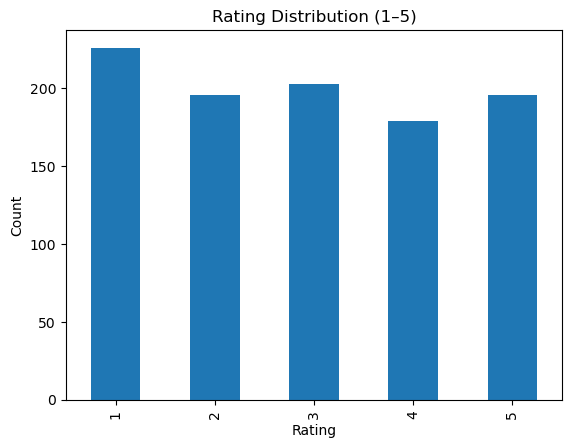

In [58]:
## 11 ##

# Plot 2: Rating distribution
plt.figure()
df['rating_num'].dropna().value_counts().sort_index().plot(kind='bar', title='Rating Distribution (1–5)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [60]:
## 12 ##

# Plot 3 PRICE vs RATING ANALYSIS
# We'll visualize how book prices vary across ratings (1–5 stars)

# Drop rows with missing values in these two columns
df_clean = df.dropna(subset=['price', 'rating_num'])

# Basic descriptive statistics
print("Average price per rating:")
print(df_clean.groupby('rating_num')['price'].describe().round(2))


Average price per rating:
            count   mean    std    min    25%    50%    75%    max
rating_num                                                        
1           226.0  34.56  13.95  10.40  22.24  34.77  45.92  59.64
2           196.0  34.81  13.61  10.02  23.85  36.22  46.25  59.95
3           203.0  34.69  14.70  10.16  22.16  33.78  47.81  59.99
4           179.0  36.09  15.08  10.01  21.92  37.80  49.44  59.45
5           196.0  35.37  15.05  10.00  21.02  36.90  49.00  59.92


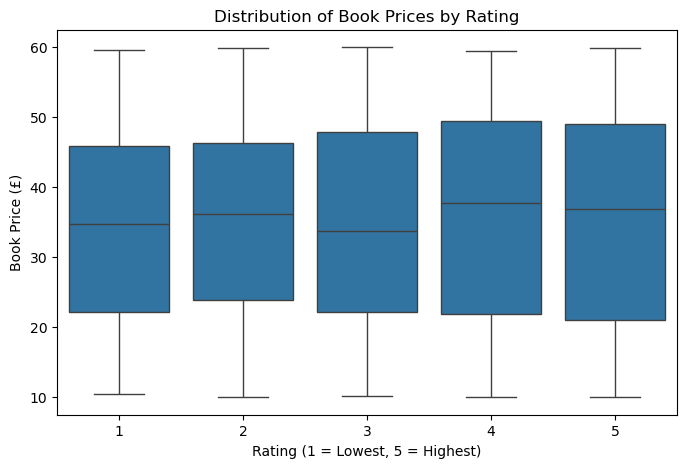

In [62]:
## 13 ##

# Boxplot — Price distribution by Rating
plt.figure(figsize=(8, 5))
sns.boxplot(x='rating_num', y='price', data=df_clean)
plt.title('Distribution of Book Prices by Rating')
plt.xlabel('Rating (1 = Lowest, 5 = Highest)')
plt.ylabel('Book Price (£)')
plt.show()

In [64]:
## 14 ##

# Correlation between price and rating
correlation = df_clean['price'].corr(df_clean['rating_num'])
print(f"Correlation between price and rating: {correlation:.3f}")

#  Interpret correlation strength
if correlation > 0.5:
    print("→ Higher-rated books tend to be more expensive.")
elif correlation < -0.5:
    print("→ Higher-rated books tend to be cheaper.")
else:
    print("→ Weak or no clear correlation between rating and price.")

Correlation between price and rating: 0.028
→ Weak or no clear correlation between rating and price.



## Copy‑Paste Cheat Sheet (for reference)

### Create & run
```bash
pip install scrapy
scrapy startproject bookdemo
cd bookdemo
scrapy genspider books books.toscrape.com
scrapy crawl books -O books.csv
```

### Minimal spider template
```python
import scrapy

class MySpider(scrapy.Spider):
    name = "myspider"
    allowed_domains = ["example.com"]
    start_urls = ["https://example.com"]

    def parse(self, response):
        for row in response.css("div.card"):
            yield {
                "title": row.css("h2::text").get(),
                "link": response.urljoin(row.css("a::attr(href)").get()),
            }

        next_href = response.css("a.next::attr(href)").get()
        if next_href:
            yield response.follow(next_href, callback=self.parse)
```

### Settings to remember
```python
# settings.py or spider.custom_settings
ROBOTSTXT_OBEY = True
DOWNLOAD_DELAY = 0.5
AUTOTHROTTLE_ENABLED = True
FEEDS = {"output.csv": {"format": "csv", "overwrite": True}}
USER_AGENT = "Scrapy-Teaching-Bot (+https://example.org/edu)"
```
